In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,2708.0,0.410978,0,0,0,0,0,1,...,0,0,1,1,0,0,1,1,0,-41
1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,1558.0,0.236425,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,-39
2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,360.0,0.054586,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,-41
3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,2602.0,0.394889,0,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,-42
4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,1844.0,0.279835,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,-42


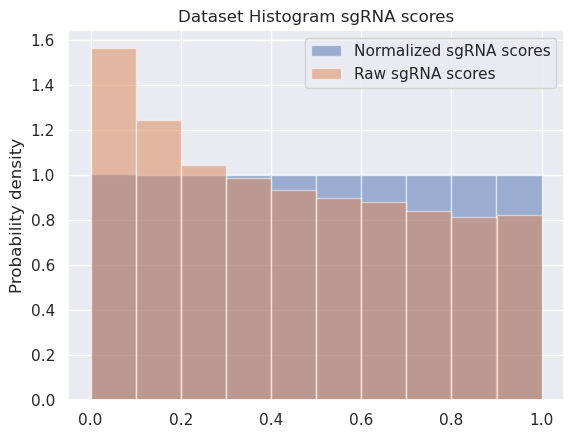

In [2]:
df = pd.read_csv("../data/Doench_Fusi_V2_Featurized.csv", index_col=0)
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("Dataset Histogram sgRNA scores")
plt.legend()
df.head()

In [3]:
df.shape

(6588, 2495)

In [4]:
from gensim.models import Word2Vec

def w2vEmbedding(texts, embeddingSize=200) -> Word2Vec:
    # Train the Word2Vec model from Gensim. 
    # Below are the hyperparameters that are most relevant. 
    # But feel free to explore other 
    # options too:
    sg = 1 # skip-gram
    window = 5
    vector_size = embeddingSize
    min_count = 1

    model = Word2Vec(sg=sg, window=window, vector_size=vector_size, min_count=min_count)
    model.build_vocab(texts)
    return model

In [5]:
EMBEDDINGS_SIZE = 25

w2vmodel_sequence = w2vEmbedding(df["Expanded Sequence"], EMBEDDINGS_SIZE)

In [6]:
print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_shakespeare = len(w2vmodel_sequence.wv)

Vocab size 4


In [7]:
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

In [8]:
embeddings = []
for _seq in df["Expanded Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

In [9]:
np.array(embeddings).shape

(6588, 750)

In [10]:
np.array(embeddings).dtype

dtype('float32')

In [11]:
df["Embedded Sequences"] = embeddings

In [12]:
dfEmb = df.copy(deep=True)[["Expanded Sequence", "sgRNA Normalized", "Embedded Sequences"]]

In [13]:
_emb = np.array(embeddings)
dfEmb["Embedded Sequences"] = embeddings

In [15]:
dfEmb.dtypes

Expanded Sequence      object
sgRNA Normalized      float64
Embedded Sequences     object
dtype: object

In [16]:
np.array(dfEmb["Embedded Sequences"][0]).dtype

dtype('float32')

In [17]:
import csv
dfEmb.to_csv("embedded sequence data.csv", quoting=csv.QUOTE_NONNUMERIC)

In [18]:
dfEmb = pd.read_csv("embedded sequence data.csv")
dfEmb.head()

,Unnamed: 0,Expanded Sequence,sgRNA Normalized,Embedded Sequences
0,0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.410978,"[-0.002144909, 0.0009457254, 0.020413399, 0.03..."
1,1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.236425,"[-0.03263167, 0.017983193, -0.016548304, 0.003..."
2,2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.054586,"[-0.03263167, 0.017983193, -0.016548304, 0.003..."
3,3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.394889,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
4,4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.279835,"[-0.03263167, 0.017983193, -0.016548304, 0.003..."


In [47]:
from sklearn.model_selection import train_test_split
from ast import literal_eval

X = [literal_eval(_x) for _x in dfEmb["Embedded Sequences"].values]
Y = np.array(dfEmb["sgRNA Normalized"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [48]:
X_train_np = np.array([np.array(a) for a in X_train])
X_test_np = np.array([np.array(a) for a in X_test])

In [49]:
X_train_np

array([[-0.03263167,  0.01798319, -0.0165483 , ...,  0.03845897,
         0.01992823,  0.03693257],
       [-0.01362146, -0.00378561,  0.02307429, ..., -0.02816624,
         0.00360582,  0.02557014],
       [-0.01362146, -0.00378561,  0.02307429, ..., -0.00581496,
        -0.03683257,  0.01748221],
       ...,
       [-0.01362146, -0.00378561,  0.02307429, ..., -0.02816624,
         0.00360582,  0.02557014],
       [-0.00214491,  0.00094573,  0.0204134 , ...,  0.02703077,
         0.00305146,  0.02540356],
       [-0.03263167,  0.01798319, -0.0165483 , ..., -0.02816624,
         0.00360582,  0.02557014]])

In [21]:
def data_generator(X: list, y: list, num_sequences_per_batch: int) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''

    index = 0
    while (index < len(y)):
        yield (np.array(X[index:index+num_sequences_per_batch]), np.array(y[index:index+num_sequences_per_batch], dtype="float32"))
        index += num_sequences_per_batch


In [22]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# https://towardsdatascience.com/regression-modelling-with-tensorflow-made-easy-train-your-first-model-in-10-minutes-497d829c7338
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

2025-11-14 22:14:53.364850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 22:14:53.996684: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-11-14 22:14:53.996748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-11-14 22:14:53.996754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [50]:
model = Sequential([
    Dense(500, activation='relu'),
    Dense(125, activation='relu'),
    Dense(1)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

In [55]:
train_generator = data_generator(X_train_np, Y_train, 256)
steps_per_epoch = len(Y_train) // 256

In [56]:
X_train_np[0]

array([-0.03263167,  0.01798319, -0.0165483 ,  0.00329814,  0.03399448,
       -0.01784871,  0.01807   , -0.02714784, -0.01419395,  0.03759403,
       -0.00631061,  0.00128549, -0.01656252, -0.03073075, -0.00603203,
        0.00987918, -0.00355211,  0.02213465, -0.01097191,  0.00904026,
        0.02182318,  0.03338381, -0.00581496, -0.03683257,  0.01748221,
       -0.03263167,  0.01798319, -0.0165483 ,  0.00329814,  0.03399448,
       -0.01784871,  0.01807   , -0.02714784, -0.01419395,  0.03759403,
       -0.00631061,  0.00128549, -0.01656252, -0.03073075, -0.00603203,
        0.00987918, -0.00355211,  0.02213465, -0.01097191,  0.00904026,
        0.02182318,  0.03338381, -0.00581496, -0.03683257,  0.01748221,
       -0.03263167,  0.01798319, -0.0165483 ,  0.00329814,  0.03399448,
       -0.01784871,  0.01807   , -0.02714784, -0.01419395,  0.03759403,
       -0.00631061,  0.00128549, -0.01656252, -0.03073075, -0.00603203,
        0.00987918, -0.00355211,  0.02213465, -0.01097191,  0.00

In [58]:
model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=1, use_multiprocessing=False)

StopIteration: 

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TT_PAM,GC Count,Melting Temp Wallace,Melting Temp GC,Melting Temp NN1,Melting Temp NN2,Melting Temp NN3,Melting Temp NN4,GC<10,GC>10
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353,0,0,0,0,0,1,...,0,13,66,56,64,58,56,62,0,1
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003,1,0,0,1,0,1,...,0,13,66,56,68,63,59,61,0,1
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828,0,0,0,0,0,0,...,0,14,68,58,74,67,62,64,0,1
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793,0,0,0,0,0,1,...,0,13,66,56,67,63,58,59,0,1
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647,0,0,0,0,0,1,...,0,9,58,48,55,53,48,49,1,0


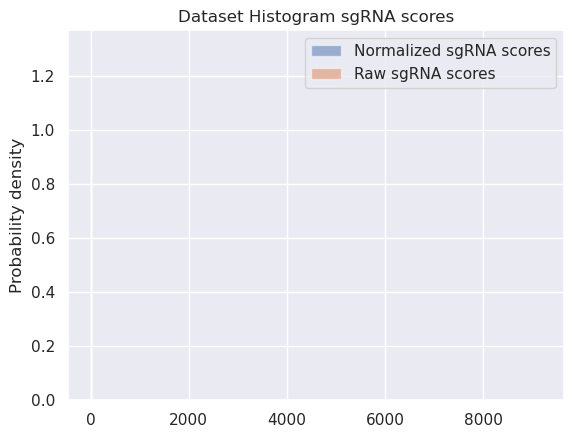

In [60]:
df = pd.read_csv("../data/KO_Data_V1_Featurized.csv", index_col=0)
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("Dataset Histogram sgRNA scores")
plt.legend()
df.head()

In [61]:
w2vmodel_ko_sequence = w2vEmbedding(df["Sequence"], EMBEDDINGS_SIZE)

In [62]:
embeddings = []
for _seq in df["Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

In [63]:
df["Embedded Sequence"] = embeddings
dfEmb = df.copy(deep=True)[["Sequence", "sgRNA Normalized", "Embedded Sequence"]]

In [64]:
dfEmb.head()

,Sequence,sgRNA Normalized,Embedded Sequence
0,TACCCTGGGACTGTACCCCC,0.604353,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003..."
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
3,TGACGCCTCGGACGTGTCTG,0.232793,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.013621463, -0.0037856055, 0.023074294, -0...."


In [65]:
import csv
dfEmb.to_csv("embedded ko sequence data.csv", quoting=csv.QUOTE_NONNUMERIC)

In [66]:
dfEmb = pd.read_csv("embedded ko sequence data.csv")
dfEmb.head()

,Unnamed: 0,Sequence,sgRNA Normalized,Embedded Sequence
0,0,TACCCTGGGACTGTACCCCC,0.604353,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
1,1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003..."
2,2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
3,3,TGACGCCTCGGACGTGTCTG,0.232793,"[0.0022871399, 0.029767632, -0.003253131, -0.0..."
4,4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.013621463, -0.0037856055, 0.023074294, -0...."


In [68]:
Y = np.array(dfEmb["sgRNA Normalized"].values)
X = [literal_eval(_x) for _x in dfEmb["Embedded Sequence"].values]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [70]:
X_train_np = np.array([np.array(a) for a in X_train])
X_test_np = np.array([np.array(a) for a in X_test])

In [72]:
model = Sequential([
    Dense(500, activation='relu'),
    Dense(125, activation='relu'),
    Dense(1)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

In [73]:
train_generator = data_generator(X_train_np, Y_train, 256)
steps_per_epoch = len(Y_train) // 256

In [ ]:
next(train_generator)

In [74]:
model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=1, use_multiprocessing=False)

202/202 [==============================] - 1s 3ms/step - loss: 0.0635 - mse: 0.0635


In [75]:
from tensorflow.keras.layers import LSTM

model = Sequential([
    LSTM(500, activation='relu'),
    LSTM(500, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

In [76]:
train_generator = data_generator(X_train_np, Y_train, 256)
steps_per_epoch = len(Y_train) // 256

In [78]:
next(train_generator)

(array([[-0.03263167,  0.01798319, -0.0165483 , ...,  0.03845897,
          0.01992823,  0.03693257],
        [-0.01362146, -0.00378561,  0.02307429, ...,  0.03845897,
          0.01992823,  0.03693257],
        [-0.00214491,  0.00094573,  0.0204134 , ...,  0.03845897,
          0.01992823,  0.03693257],
        ...,
        [-0.01362146, -0.00378561,  0.02307429, ..., -0.00581496,
         -0.03683257,  0.01748221],
        [-0.01362146, -0.00378561,  0.02307429, ...,  0.02703077,
          0.00305146,  0.02540356],
        [-0.01362146, -0.00378561,  0.02307429, ...,  0.03845897,
          0.01992823,  0.03693257]]),
 array([0.7749136 , 0.3667825 , 0.05461864, 0.6388699 , 0.10769869,
        0.847252  , 0.3034787 , 0.20445359, 0.9687632 , 0.19464682,
        0.7900021 , 0.6232563 , 0.9033127 , 0.8468659 , 0.5594583 ,
        0.37209514, 0.9082701 , 0.11969846, 0.81006354, 0.84190845,
        0.72709984, 0.79929924, 0.89857143, 0.02967703, 0.48454085,
        0.06777669, 0.9104322 , 0

In [77]:
model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=1, use_multiprocessing=False)

ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).

Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (256, 500)

Call arguments received by layer 'sequential_3' (type Sequential):
  • inputs=tf.Tensor(shape=(256, 500), dtype=float32)
  • training=False
  • mask=None